In [1]:
!pip install pycaret
!pip install python-dotenv
!pip install ydata-profiling
!pip install shap


<h3>1. Introduction </h3>
This template notebook will give users (data scientists and data engineers) the opportunities to train and deploy regression machine learning models with ease, without having to write all of the code from scratch. <br> 
There are a few requirements for the user anyway, such as;
<li>the data location</li> 
<li>algorithm_choice: what type of machine learning model you are trying to build. Regression, classification, time series etc.</li>
<li>the target (dependent) variable in your dataset and</li>
<li>endpoint_name: what you will like to call your endpoint after it is created</li>
<li>model_name: what you will like to call your model</li>
<li>data_location: the location of the datasets. Needs to be in an S3 bucket.</li>
<li>pycaret_ecr_name: what you have named the ecr image that you created </li>
<li>instance_type: the details of the instance type that you will be creating. </li>

<b>All of these values will be entered in terraform and will be automatically applied in the notebook.</b>

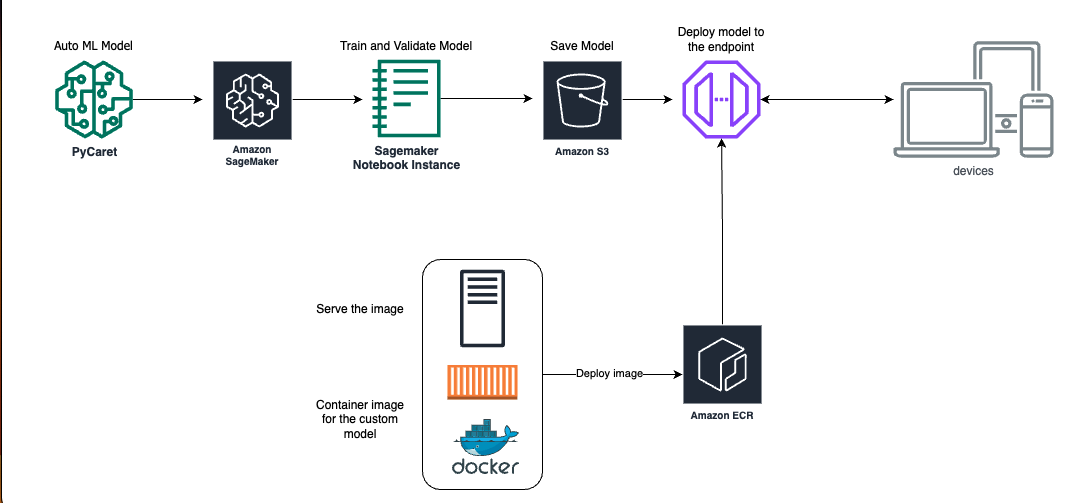

<h3>2. Imports</h3>

The libraries that are required for this model notebook are imported below 

In [2]:
import os
from sagemaker import get_execution_role
from dotenv import load_dotenv
from load_data import load_data
from split_data import split_data
import importlib
from save_model_to_s3 import save_model_to_s3
from deploy_model_endpoint import deploy_model
from finalize_and_save_model import finalize_and_save_model
from delete_sagemaker_endpoint import delete_sagemaker_endpoint
from ydata_profiling import ProfileReport
import shap


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


<h3>3. Loading Data</h3>
Here the user is required to specify the location of the data that they will like to use for prediction. An helper function is used to load the data from S3. 

<em>Note: Your data needs to be an s3 bucket.</em>

In [3]:
# Variables Setup Stage
load_dotenv(".env")
role = get_execution_role()

# Env variables
data_location_s3 = os.getenv("data_location_s3")
algorithm_choice = os.getenv("algorithm_choice")
target = os.getenv("target")
endpoint_name = os.getenv("endpoint_name")
model_name = os.getenv("model_name")
model_s3_bucket = os.getenv("model_s3_bucket")
data_location = 's3://{}'.format(data_location_s3)
instance_type = os.getenv("inference_instance_type")
inference_instance_count = int(os.getenv("inference_instance_count"))
image_uri = os.getenv("ecr_repo_uri")
tuning_metric = os.getenv("tuning_metric")

print(data_location_s3, algorithm_choice, target, endpoint_name, model_name, data_location, instance_type, image_uri, tuning_metric)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
streaming-data-platform-ml-data/ethan_data.csv classification y classification-proba-endpoint banking-classification s3://streaming-data-platform-ml-data/ethan_data.csv ml.m4.xlarge 135544376709.dkr.ecr.eu-west-1.amazonaws.com/mlops-classification-repo:latest AUC


<h3>4. Read and display a sample of data</h3>

In [4]:
# Load data from S3
df = load_data(data_location)
df.head()


Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.



,age,job,education,default,balance,housing,loan,y
0,32,7,2,1,-238,1,0,0
1,34,4,2,0,-478,1,1,0
2,32,3,2,0,266,1,0,0
3,36,7,2,1,13,0,1,0
4,23,11,2,0,486,0,0,0


<h3>5. Data Exploration</h3>

In [5]:
profile = ProfileReport(
    df,
    sort=None,
    html={"style": {"full_width": True}},
    title="Data Exploration",
    explorative=True,
)
profile.to_widgets()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
# Split and shuffle data
train_data, test_data = split_data(df, shuffle=True)
print(train_data, test_data)


       age  job  education  default  balance  housing  loan  y
0       46    7          1        0     1666        1     0  0
1       30    7          2        0     3532        1     0  0
2       37    2          3        0     2905        1     0  1
3       37    3          2        0     -797        1     0  1
4       92    8          4        0      775        0     0  1
...    ...  ...        ...      ...      ...      ...   ... ..
44649   37    3          2        0      588        1     0  0
44650   41    4          2        0      239        1     0  0
44651   65    8          1        0      543        0     0  1
44652   50    2          2        0     1716        1     0  0
44653   40    2          3        0        0        0     0  1

[44654 rows x 8 columns]        age  job  education  default  balance  housing  loan  y
44654   35    7          4        0     2298        0     0  0
44655   31    5          2        0      132        0     0  0
44656   50    4          2   

<h3>6. Data Cleaning and Feature Engineer</h3> 

Here we work on Data Cleaning and Feature Engineering before passing data down to pycaret's environment. This feature is still in progress..

In [7]:
# TBC (Just a Placeholder currently)


In [8]:
# Import Pycaret library depending on the algorithm choice
pycaret = importlib.import_module(f"pycaret.{algorithm_choice}")


In [9]:
# Initialize data in PyCaret with all the defined parameters
pycaret.setup(data=train_data, target=target, session_id=123)


,Description,Value
0,Session id,123
1,Target,y
2,Target type,Binary
3,Original data shape,"(44654, 8)"
4,Transformed data shape,"(44654, 8)"
5,Transformed train set shape,"(31257, 8)"
6,Transformed test set shape,"(13397, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


<h3>7.Model Training</h3>

Here we are using the pycaret automl tool to train the model. The automl tool tries a number of machine learning algorithms depending on the type of machine learning problem you are trying to solve <br>
(regression, classification or time series). The automl tool then selects the best model based on the accuracy metrics of the tried models. 

In [10]:
# Train and evaluate the performance of all estimators available in the model library using cross-validation.
bestModel = pycaret.compare_models()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7979,0.8768,0.8246,0.7828,0.8031,0.5958,0.5968,1.4370
dt,Decision Tree Classifier,0.7855,0.7904,0.8169,0.7685,0.7919,0.5709,0.5721,0.0650
et,Extra Trees Classifier,0.7729,0.8611,0.7977,0.7600,0.7783,0.5458,0.5465,1.1060
lightgbm,Light Gradient Boosting Machine,0.7632,0.8401,0.7791,0.7551,0.7668,0.5263,0.5267,0.7680
knn,K Neighbors Classifier,0.7564,0.8402,0.8639,0.7110,0.7800,0.5129,0.5253,0.1020
gbc,Gradient Boosting Classifier,0.7392,0.8125,0.7601,0.7297,0.7445,0.4785,0.4790,1.0040
ada,Ada Boost Classifier,0.7252,0.7954,0.7574,0.7116,0.7338,0.4504,0.4514,0.3740
ridge,Ridge Classifier,0.7174,0.0000,0.7720,0.6961,0.7320,0.4349,0.4376,0.0250
lda,Linear Discriminant Analysis,0.7174,0.7577,0.7720,0.6961,0.7320,0.4349,0.4376,0.0390
lr,Logistic Regression,0.7134,0.7486,0.7750,0.6900,0.7300,0.4268,0.4302,0.8080


<h3>7.5. Hyperparameter Tuning: </h3>

Here we optimize the model using hyperparameter tuning. This can be done by using pycaret automatic hyperparameter tuning function, or choosing the metric user want to focus on optimizing eg. MAE, RMSE for regression, and Accuracy, AUC for classification. User can also specify how many iteration user want to run (default is 10 iterations).

This can be done by using these commands
```
pycaret.tune_model(model)
pycaret.tune_model(model, n_iter = <number of iteration>)
pycaret.tune_model(model, optimize = '<Metric>')
```

In the case where original model has a better performance, pycaret will return the original model


In [11]:
bestModel = pycaret.tune_model(bestModel, n_iter = 10, optimize = tuning_metric)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7306,0.8003,0.7663,0.7151,0.7398,0.4613,0.4625
1,0.7191,0.7866,0.7618,0.7017,0.7305,0.4383,0.4399
2,0.7271,0.8030,0.7806,0.7052,0.7410,0.4543,0.4569
3,0.7169,0.7887,0.7626,0.6987,0.7293,0.4338,0.4356
4,0.7278,0.8010,0.7767,0.7075,0.7405,0.4555,0.4577
5,0.7284,0.8076,0.7857,0.7049,0.7431,0.4568,0.4598
6,0.7194,0.7914,0.7774,0.6967,0.7348,0.4389,0.4419
7,0.7114,0.7819,0.7798,0.6858,0.7298,0.4227,0.4268
8,0.7197,0.7983,0.7804,0.6958,0.7357,0.4394,0.4427


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [12]:
# View the model's hyperparameter
print(bestModel)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)


<h3>8. Model Evaluation: </h3>

Here we evaluate the performance of the best model, getting some visual representation of hyperparameters, features and other important details about the selected model.


In [13]:
# Evaluate model: Display UI analyzing Hyperparameters, Confusion Matrix, Class Report, etc.
pycaret.evaluate_model(bestModel)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

<h3>9. Saving Model for future predition</h3>

Here we are using a function that saves the model to s3. 

In [14]:
# Finalising model and save the model to current directory
final_model = finalize_and_save_model(algorithm_choice, bestModel, model_name)


Transformation Pipeline and Model Successfully Saved


In [15]:
final_prediction = pycaret.predict_model(final_model, data=test_data)
final_prediction.head()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8152,0.8959,0.8396,0.8008,0.8197,0.6304,0.6311


,age,job,education,default,balance,housing,loan,y,prediction_label,prediction_score
44654,35,7,4,0,2298,0,0,0,1,0.590
44655,31,5,2,0,132,0,0,0,1,0.960
44656,50,4,2,0,1375,0,0,1,0,0.610
44657,30,1,3,0,734,1,0,0,0,1.000
44658,36,4,2,0,1305,1,0,1,1,0.531


# Upload model to s3
save_model_to_s3(model_name, model_s3_bucket)

<h3>Model explainability functions:</h3>

This visualization is designed to explain the output of a single prediction by showing the contribution of each feature to the final prediction, compared to a base value.


<li><b>Base Value:</b> The base value is the reference point for the model's predictions. It's the value that would be predicted if we didn't know any features for the current output. In SHAP, this is typically the mean prediction of the model over the training dataset.</li>
<li><b>Output Value (f(x)):</b> This is the actual prediction for the instance being explained. This value is the sum of the base value and all of the SHAP values (feature contributions) for this prediction.</li>
<li><b>Red and Blue Arrows:</b> Each arrow represents a feature that contributes to the prediction. Features pushing the prediction higher (toward the right) are shown in red, and those pushing the prediction lower (toward the left) are shown in blue. The length of each arrow represents the magnitude of the feature's contribution.</li>
<li><b>Red:</b> The feature increases the model's prediction. Pushes the prediction to a higher value, indicating that this feature has a positive impact on the prediction.</li>
<li><b>Blue:</b> If there were any, blue would indicate features that push the model's prediction to a lower value.</li>

### Shap Summary Plot
We will use summary_plot. This type of plot aggregates SHAP values for all the features and all samples in the selected set. Then SHAP values are sorted, so the first one shown is the most important feature. In addition to that, we are provided with information of how each feature affects the model output.

ExactExplainer explainer: 11165it [21:57,  8.43it/s]                           


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

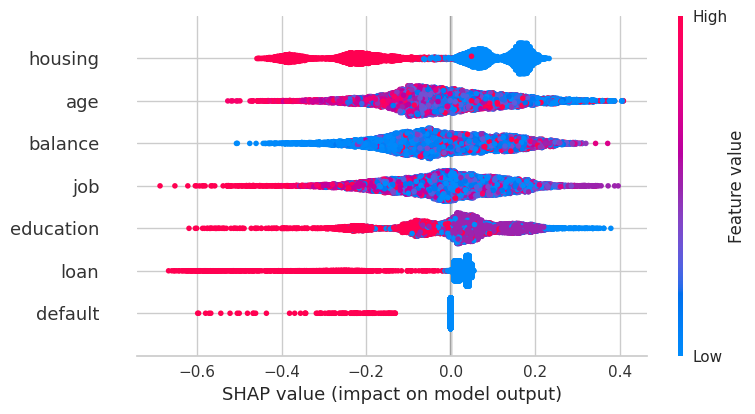

In [17]:
test_features = test_data.copy().drop(target, axis=1)

explainer = shap.Explainer(final_model.predict, test_features)

# Generate SHAP values for your test features
shap_values = explainer(test_features)

base_value = shap_values.base_values[0]  # This is for a single output model

shap_values_array = shap_values.values
# Visualize the first prediction's explanation
shap.initjs()

# Plotting the summary plot for all features across all test samples
shap.summary_plot(shap_values_array, test_features)


In [18]:
shap_values_array = shap_values.values[0]

shap.force_plot(base_value, shap_values_array, test_features.iloc[0])


<h3>10. Deploying the model endpoints</h3> 

Here we use a function that creates the model endpoint in sagemaker. 

In [21]:
# deploy model to sagemaker endpoint
deploy_model(model_name, algorithm_choice, model_s3_bucket, instance_type, endpoint_name, role, inference_instance_count, image_uri)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
-------!

# Clean up stage
## Remove Endpoint and Endpoint Config

In [20]:
delete_sagemaker_endpoint(endpoint_name)


Are you sure you want to delete the endpoint 'classification-proba-endpoint'? Type 'Yes' to confirm: Yes
Endpoint 'classification-proba-endpoint' and its configuration have been deleted.
